In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
from core.models import MNISTDense
from core.initializers import He, Xavier
from core.optimizers import GradDesc, Momentum
from core.losses import Crossentropy
from core.activations import ReLu, Softmax

## Считывание данных из бинарных файлов

In [3]:
project_path =  Path.cwd().parent
data_path = project_path / "data"
preproc_path = data_path / "preprocessed"

source_train_im_path = preproc_path / "train-images-idx3-ubyte.bin"
source_train_l_path = preproc_path / "train-labels-idx1-ubyte.bin"
source_test_im_path = preproc_path / "t10k-images-idx3-ubyte.bin"
source_test_l_path = preproc_path / "t10k-labels-idx1-ubyte.bin"


### Обучающая выборка

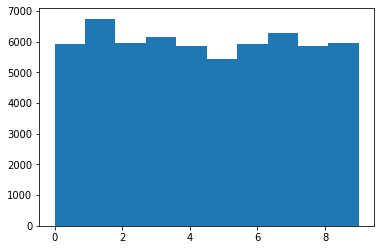

In [4]:
# Метки обуающей выборки
train_labels = np.fromfile(source_train_l_path, dtype=np.uint8, offset=8)
plt.hist(train_labels);

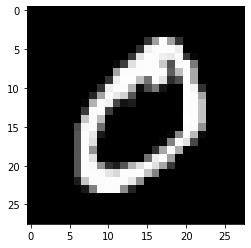

In [5]:
# Изображения обучающей выборки
train_size, rows, columns = 60000, 28, 28
train_images = np.fromfile(source_train_im_path, dtype=np.uint8, offset=16).reshape((train_size, rows, columns))
plt.imshow(train_images[1,:,:], cmap='gray')

### Тестовая выборка

In [6]:
# Метки тестовой выборки
# test_labels = np.fromfile(source_test_l_path, dtype=np.uint8, offset=8)
# plt.hist(test_labels);

In [7]:
# Изображения тестовой выборки
# test_size, rows, columns = 10000, 28, 28
# test_images = np.fromfile(source_test_im_path, dtype=np.uint8, offset=16).reshape((test_size, rows, columns))
# plt.imshow(test_images[1,:,:], cmap='gray')

## Создадим модель 

In [8]:
n_train = 30000
n_classes = 10
prepared_labels = train_labels[:n_train]
prepared_images = train_images[:n_train].reshape(n_train, -1)
prepared_images = (prepared_images > 0).astype(np.uint8)

In [13]:
model_grad = MNISTDense(
    input_size=28*28,
    layers_sizes=[64, 32, 10],
    initializers_classes=[He, He, Xavier],
    activations_classes=[ReLu, ReLu, Softmax],
    optimizer=GradDesc(0.00001),
    loss=Crossentropy
)
history_grad = model_grad.fit(5, 32, prepared_images, prepared_labels)

By epoch progress


100%|██████████| 5/5 [00:22<00:00,  4.44s/it]


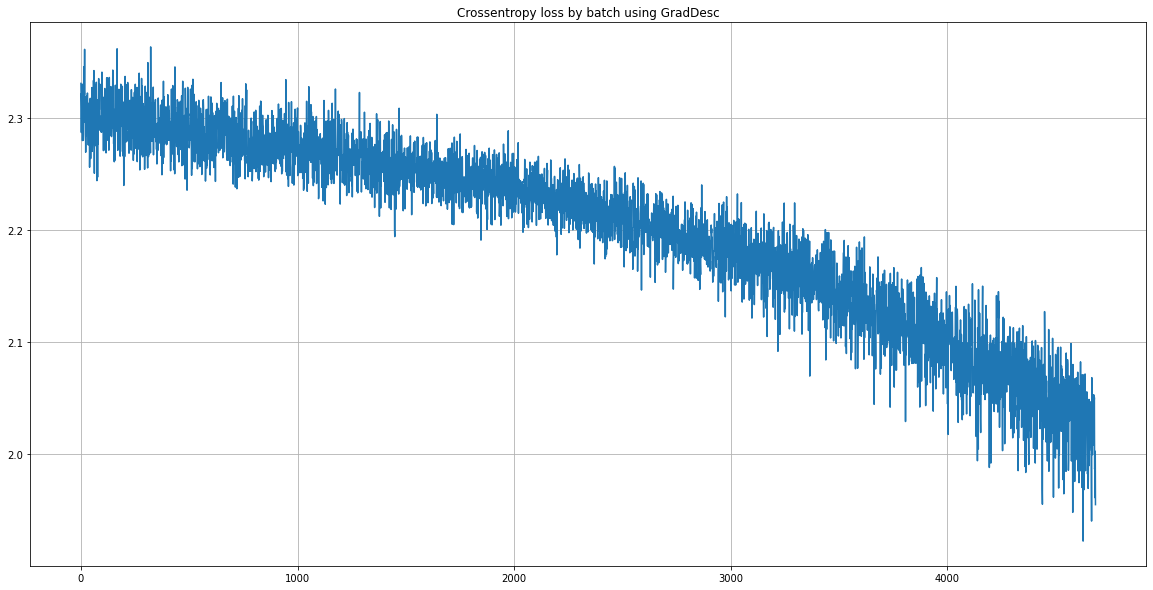

In [14]:
plt.figure(figsize=(20,10))
plt.title("Crossentropy loss by batch using GradDesc")
plt.grid()
plt.plot(history_grad.flatten())

In [23]:
model_momentum = MNISTDense(
    input_size=28*28,
    layers_sizes=[64, 32, 10],
    initializers_classes=[He, He, Xavier],
    activations_classes=[ReLu, ReLu, Softmax],
    optimizer=Momentum(learning_rate=0.00001, momentum=0.5),
    loss=Crossentropy
)
history_momentum = model_momentum.fit(5, 32, prepared_images, prepared_labels)

By epoch progress


100%|██████████| 5/5 [00:19<00:00,  3.87s/it]


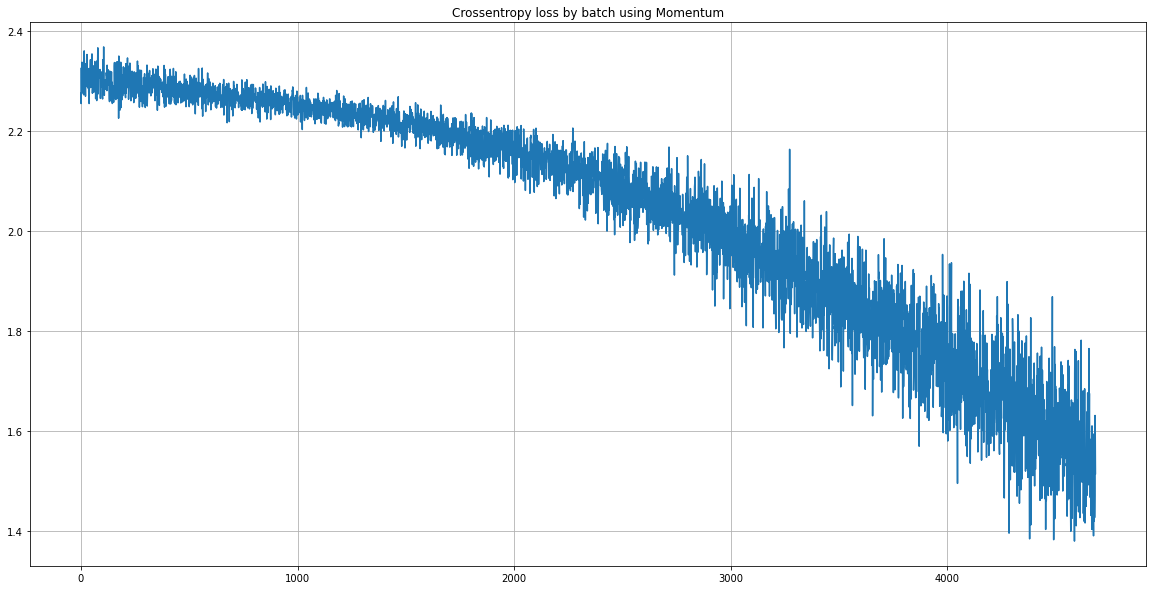

In [24]:
plt.figure(figsize=(20,10))
plt.title("Crossentropy loss by batch using Momentum")
plt.grid()
plt.plot(history_momentum.flatten())